# QAQC for tanker traffic
- Validate cargo capacities by investigating AIS data and the DOE transfers for vessels recorded by AIS. 
  

In [1]:
# import necessary packages
import os
import pandas
import numpy
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import geopandas as gpd
from pathlib import Path
# import function for querying DOE dataframes
from dask import delayed
from monte_carlo_utils import get_DOE_df

# set file location and name
doe_xls_path = Path('/data/MIDOSS/spreadsheets/MuellerTrans4-30-20.xlsx')
fac_xls_path = Path(
    '/home/rmueller/Projects/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx'
)

# import facility locations
facWA = pandas.read_excel(
    fac_xls_path,
    sheet_name = 'Washington',
    usecols="B,D,J,K"
)

# import facility locations
facCAD = pandas.read_excel(
    fac_xls_path,
    sheet_name = 'British Columbia',
    usecols="A",
    nrows=10
)
mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

from monte_carlo_utils import get_DOE_df
DOEdf = get_DOE_df(
    doe_xls_path, 
    fac_xls_path,
    group = 'no'
)

In [2]:
def concat_shp(ship_type):
    """
      INPUT: 
          - ship_type ["tanker", "barge", "atb", etc]: MIDOSS-name for ship type (see oil_attribution.yaml for list)
      OUTPUT: 
          - dataframe of all 2018 ship tracks for given ship_type
      requirements: 
          This script requires being run on Salish.eoas.ubc.ca, with path to shapefiles being /data/MIDOSS/shapefiles/
    """
    for months in range(1,13):
        # set file location and name
        shp_path = Path(f'/data/MIDOSS/shapefiles/{ship_type}_2018_{months:02d}.shp')
        # import shapefile using geopandas
        monthly_shp = gpd.read_file(shp_path)
        if months == 1:
            print(f'creating {ship_type} shapefile for 2018, starting with January data')
            allTracks = monthly_shp
        else:
            print(f'Concatenating {ship_type} data from month {months}')
            allTracks = gpd.GeoDataFrame(
                pandas.concat([allTracks, monthly_shp])
            )
    return allTracks

In [51]:
def get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path):
    """
        Inputs:
            - vessels [list]: List of vessel names, e.g.["AMERICAN FREEDOM","PELICAN STATE"]
            - doe_xls_path [path]: Location and name of DOE data spreadsheet
            - fac_xls_path [path]: Location and name of facilities transfer spreadsheet
        Outputs:
            - cargo_transfers [dataframe]: 2018 cargo transfers to/from the vessels and 
               the marine terminals used in this study, in liters.  Transfers are grouped by AntID
    """
    # conversion factor
    gal2liter = 3.78541
    # load dept. of ecology data
    DOEdf = get_DOE_df(
        doe_xls_path, 
        fac_xls_path,
        group = 'no'
    )
    # extract tanker cargo transfers
    cargo_transfers = DOEdf.loc[
        (DOEdf.TransferType == 'Cargo') &
        (DOEdf.Deliverer.isin(vessels) |
         DOEdf.Receiver.isin(vessels)),
        ['TransferQtyInGallon', 'Deliverer','Receiver','StartDateTime','AntID']
    ].groupby('AntID').agg(
        {'TransferQtyInGallon':'sum',
         'Deliverer':'first', 
         'Receiver':'first',
         'StartDateTime':'first'}
        ).sort_values(by='TransferQtyInGallon',ascending=False)
    # convert to liters
    cargo_transfers['TransferQtyInGallon'] = gal2liter*cargo_transfers['TransferQtyInGallon']
    cargo_transfers=cargo_transfers.rename(
        columns={"TransferQtyInGallon":"TransferQtyInLiters"}
    )

    return cargo_transfers


In [52]:
def get_doe_byVesselType(type_description,doe_xls_path,fac_xls_path):
    """
        Inputs:
            - type_description [list]: List of vessel type, e.g.['TANK SHIP']
            - doe_xls_path [path]: Location and name of DOE data spreadsheet
            - fac_xls_path [path]: Location and name of facilities transfer spreadsheet
        Outputs:
            - cargo_transfers [dataframe]: 2018 cargo transfers to/from the vessels and 
               the marine terminals used in this study, in liters.  Transfers are grouped by AntID
    """
    # conversion factor
    gal2liter = 3.78541
    # load dept. of ecology data
    DOEdf = get_DOE_df(
        doe_xls_path, 
        fac_xls_path,
        group = 'no'
    )
    # extract tanker cargo transfers
    cargo_transfers = DOEdf.loc[
        (DOEdf.TransferType == 'Cargo') &
        (DOEdf.DelivererTypeDescription.isin(type_description) |
         DOEdf.ReceiverTypeDescription.isin(type_description)),
        ['TransferQtyInGallon', 'StartDateTime','AntID']
    ].groupby('AntID').agg(
        {'TransferQtyInGallon':'sum','StartDateTime':'first'}
        ).sort_values(by='TransferQtyInGallon',ascending=False)

    cargo_transfers['TransferQtyInGallon'] = gal2liter*cargo_transfers['TransferQtyInGallon']
    cargo_transfers=cargo_transfers.rename(
        columns={"TransferQtyInGallon":"TransferQtyInLiters"}
    )
    return cargo_transfers

In [5]:
def bins_labels(bins, **kwargs):
    """
    Labels x-axis of histogram with labels in center of bar
    Inputs:
        - bins [vector]: e.g. bins = numpy.arange(0,1.7e8,1e7)
    """
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(numpy.arange(min(bins)+bin_w/2, max(bins)+2*bin_w/2, bin_w), bins, **kwargs, rotation=90)
    plt.xlim(bins[0], bins[-1])
    

### Concat 2018 tanker traffic AIS

In [6]:
%%time
allTracks={} # adopted from another notebook
ship_type = "tanker"
allTracks["tanker"] = concat_shp("tanker")

creating tanker shapefile for 2018, starting with January data
Concatenating tanker data from month 2
Concatenating tanker data from month 3
Concatenating tanker data from month 4
Concatenating tanker data from month 5
Concatenating tanker data from month 6
Concatenating tanker data from month 7
Concatenating tanker data from month 8
Concatenating tanker data from month 9
Concatenating tanker data from month 10
Concatenating tanker data from month 11
Concatenating tanker data from month 12
CPU times: user 1min 17s, sys: 2.25 s, total: 1min 20s
Wall time: 1min 20s


In [7]:
# This is needed for later one, when I use enumerate(allTracks["tanker"]["LENGTH"])
# to bin MMSI and vessel lengths according to our criteria for different tanker lengths
allTracks["tanker"] = allTracks["tanker"].reset_index(drop=True)

### MMSI 368009250 is for GLOBAL PROVIDER
- This is the only ship < 60 m
- Check max fuel transfers to get capacity estimate for this size class (42 feet)

In [8]:
GP_df={}
GP_df["Cargo"] = get_doe_tanker_byvessel(['GLOBAL PROVIDER'],doe_xls_path,fac_xls_path)
GP_df["Cargo"].TransferQtyInLiters.max()

588252.714

<AxesSubplot:>

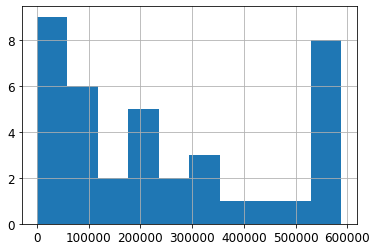

In [9]:
GP_df["Cargo"].TransferQtyInLiters.hist()

### Cargo capacity for Global Provider ~ 155400 Gallons

In [10]:
sm_tankers = allTracks["tanker"].loc[
    (allTracks["tanker"]["LENGTH"]>60) & 
    (allTracks["tanker"]["LENGTH"]<155),
    ['LENGTH','MMSI_NUM']
]
numpy.median(sm_tankers['LENGTH'])

144.0

Text(0.5, 1.0, 'Ship track count for tankers < 155 m')

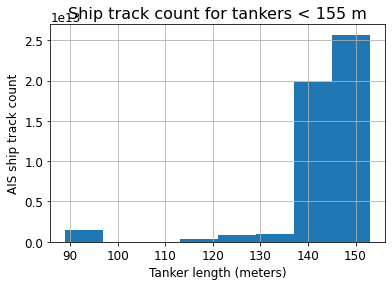

In [11]:
hist=sm_tankers.LENGTH.hist(weights=sm_tankers.MMSI_NUM, bins=8)
hist.set_ylabel('AIS ship track count')
hist.set_xlabel('Tanker length (meters)')
hist.set_title('Ship track count for tankers < 155 m')

#### create histogram for all tanker lenghts and mmsi

Text(0.5, 1.0, 'Ship track count for all tankers')

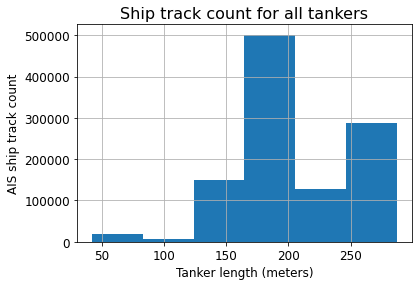

In [12]:
all_tankers = allTracks["tanker"][['LENGTH','MMSI_NUM']].groupby('LENGTH').count().sort_values(by='MMSI_NUM',ascending=False).reset_index()
hist=all_tankers.LENGTH.hist(weights=all_tankers.MMSI_NUM, bins=6)
hist.set_ylabel('AIS ship track count')
hist.set_xlabel('Tanker length (meters)')
hist.set_title('Ship track count for all tankers')

In [13]:
### The top three receivers of DOE transfers are for KIRKEHOLMEN, OVERSEAS LOS ANGELES, and PELICAN STATE

## Create histogram of tanker lengths

In [14]:
from monte_carlo_utils import get_bin

bins = []
bins.append((0, 60))
bins.append((61, 150))
bins.append((151, 200))
bins.append((201, 250))
bins.append((251, 300))

size_classes = [
    "Smallest Tanker (< 60 m)",
    "Small Tanker (61 - 150 m)", 
    "Handymax (151-200 m)", 
    "Aframax (201-250 m)", 
    "Suezmax (251-300 m)" 
]
binned_data = numpy.zeros(len(bins))
binned_mmsi = pandas.DataFrame(columns = size_classes)
for idx,value in enumerate(allTracks["tanker"]["LENGTH"]):
    if value > 0:
        bin_index = get_bin(value, bins)  
        binned_data[bin_index] += 1    

0 19025.0
1 84730.0
2 572427.0
3 142846.0
4 272345.0


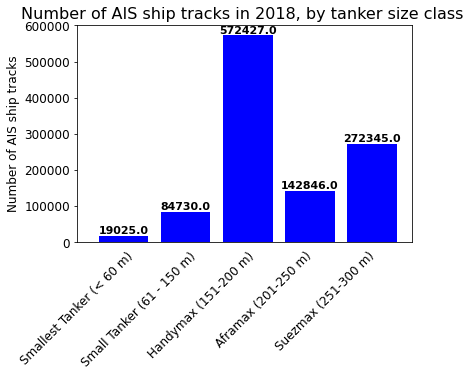

In [15]:
fig, ax = plt.subplots()    
#width = 0.75 # the width of the bars 
ind = numpy.arange(len(binned_data))  # the x locations for the groups
ax.bar(ind, binned_data, color="blue")
ax.set_xticks(ind-3/4)
ax.set_xticklabels(size_classes, minor=False, rotation=45)
ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
plt.title('Number of AIS ship tracks in 2018, by tanker size class ')
#plt.xlabel('Tanker size class', rotation=45)
plt.ylabel('Number of AIS ship tracks')
for i, v in enumerate(binned_data):
    print(i,v)
    ax.text(i, v, str(v), color='black', fontweight='bold', ha='center', va='bottom')

In [16]:
size_classes

['Smallest Tanker (< 60 m)',
 'Small Tanker (61 - 150 m)',
 'Handymax (151-200 m)',
 'Aframax (201-250 m)',
 'Suezmax (251-300 m)']

In [17]:
binned_mmsi = {}
for idx,sizeclass in enumerate(size_classes):
    #print(idx,sizeclass)
    binned_mmsi[sizeclass]= allTracks["tanker"].loc[
        (allTracks["tanker"]["LENGTH"] > bins[idx][0]) & 
        (allTracks["tanker"]["LENGTH"] < bins[idx][1]),
        ['MMSI_NUM','LENGTH']
    ].groupby('MMSI_NUM').count().sort_values(by='LENGTH',ascending=False).rename(columns={'LENGTH':'COUNT'})
    print(sizeclass)
    print(binned_mmsi[sizeclass])

Smallest Tanker (< 60 m)
             COUNT
MMSI_NUM          
368009250.0  19025
Small Tanker (61 - 150 m)
             COUNT
MMSI_NUM          
355320000.0  33381
566306000.0   6427
477636500.0   6416
477493700.0   5874
316014610.0   4715
477173600.0   4299
373353000.0   4129
538006371.0   3472
351456000.0   2695
371823000.0   2408
357299000.0   1911
538005277.0   1869
212744000.0   1726
477229900.0   1703
538006828.0   1582
373474000.0   1376
538003481.0    336
372405000.0    319
316041640.0     92
Handymax (151-200 m)
             COUNT
MMSI_NUM          
369042000.0  41383
367353110.0  37996
366855000.0  32830
367134000.0  31026
369040000.0  26513
...            ...
563654000.0    229
371394000.0    213
538006805.0    166
477858900.0     51
257005000.0     48

[140 rows x 1 columns]
Aframax (201-250 m)
             COUNT
MMSI_NUM          
636015178.0   6057
220518000.0   5718
255806154.0   5140
311943000.0   4609
538001893.0   4172
...            ...
538002946.0    698
309038000.

In [18]:
for sizeclass in size_classes:
    print(f'{binned_mmsi[sizeclass].shape[0]} {sizeclass} vessels')

1 Smallest Tanker (< 60 m) vessels
19 Small Tanker (61 - 150 m) vessels
140 Handymax (151-200 m) vessels
69 Aframax (201-250 m) vessels
29 Suezmax (251-300 m) vessels


In [19]:
total = binned_mmsi['Handymax (151-200 m)'].COUNT.iloc[0]
for index in [1,2,3,4,5,6,7,8,9,10,11]:
    total+=binned_mmsi['Handymax (151-200 m)'].COUNT.iloc[index]
print(f'We are using volume estimate from {100*total/binned_mmsi["Handymax (151-200 m)"].COUNT.sum():.2f} percent of HandiMax traffic')

We are using volume estimate from 46.37 percent of HandiMax traffic


In [20]:
binned_mmsi['Handymax (151-200 m)'] 

,COUNT
MMSI_NUM,
369042000.0,41383
367353110.0,37996
366855000.0,32830
367134000.0,31026
369040000.0,26513
...,...
563654000.0,229
371394000.0,213
538006805.0,166


In [21]:
binned_mmsi['Handymax (151-200 m)'].iloc[0:10].index

Float64Index([369042000.0, 367353110.0, 366855000.0, 367134000.0, 369040000.0,
              356159000.0, 212656000.0, 538006302.0, 538004682.0, 538007277.0],
             dtype='float64', name='MMSI_NUM')

In [22]:
#'PANAGIA THALASSINI','CHEMBULK LINDY ALICE','ZAO GALAXY','OVERSEAS LOS ANGELES','AMERICAN ENDURANCE','OPEC VICTORY','SONGA PRIDE',

## Find vessel names for mmsi through myshiptracking.com

In [45]:
binned_mmsi['Handymax (151-200 m)'].iloc[0:20]

,COUNT
MMSI_NUM,
369042000.0,41383
367353110.0,37996
366855000.0,32830
367134000.0,31026
369040000.0,26513
356159000.0,17697
212656000.0,15659
538006302.0,15417
538004682.0,13344


In [23]:
mmsi_names = {368009250:"GLOBAL PROVIDER",
    355320000:"KIRKEHOLMEN",
    369042000:"AMERICAN FREEDOM",
    367353110:"PELICAN STATE", 
    366855000:          
    636015178:"AQUALEGACY",
    220518000:"TORM EMILIE",
    303294000:"ALASKAN EXPLORER",
    367688000:"ALASKAN NAVIGATOR"}
mmsi_sizeclass = {368009250:"Smallest Tanker (< 60 m)",
    355320000:"Small Tanker (61 - 150 m)",
    369042000:"Handymax (151-200 m)",
    367353110:"Handymax (151-200 m)", 
                  
    636015178:"Aframax (201-250 m)",
    220518000:"Aframax (201-250 m)",
    303294000:"Suezmax (251-300 m)",
    367688000:"Suezmax (251-300 m)"}

## Search DOE for names and return max transfer volume

In [24]:
[*mmsi_names]

[368009250,
 355320000,
 369042000,
 367353110,
 636015178,
 220518000,
 303294000,
 367688000]

## Loop through each mmsi and get max transfer volume for AntID

In [25]:
export_by_vessel = {}
import_by_vessel = {}
transfer_type = 'Cargo'
print('~~~ EXPORTS ~~~')
print('mmsi', '\t max transfer volume (liters)','size class')
gal2liter = 3.78541
for idx,mmsi in enumerate([*mmsi_names]):    
    export_by_vessel[mmsi_names[mmsi]] = DOEdf.loc[
        DOEdf.Receiver == mmsi_names[mmsi],
        ['TransferQtyInGallon','AntID','TransferType','StartDateTime']
    ].groupby('AntID').agg(
        {'TransferQtyInGallon':'max','TransferType':'first','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)
    #print out max transfer volume for mmsi
    print(mmsi, 
          f'{gal2liter*max(export_by_vessel[mmsi_names[mmsi]]["TransferQtyInGallon"]):.2e}\t',
         mmsi_sizeclass[mmsi])
print('~~~ IMPORTS ~~~')
for idx,mmsi in enumerate([*mmsi_names]):    
    import_by_vessel[mmsi_names[mmsi]] = DOEdf.loc[
        DOEdf.Deliverer == mmsi_names[mmsi],
        ['TransferQtyInGallon','AntID',"TransferType",'StartDateTime']
    ].groupby('AntID').agg(
        {'TransferQtyInGallon':'max','TransferType':'first','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)
    #print out max transfer volume for mmsi
    if not import_by_vessel[mmsi_names[mmsi]]["TransferQtyInGallon"].empty:
        print(mmsi, 
              f'{gal2liter*max(import_by_vessel[mmsi_names[mmsi]]["TransferQtyInGallon"]):.2e}\t',
             mmsi_sizeclass[mmsi])

~~~ EXPORTS ~~~
mmsi 	 max transfer volume (liters) size class
368009250 5.88e+05	 Smallest Tanker (< 60 m)
355320000 1.51e+07	 Small Tanker (61 - 150 m)
369042000 2.38e+07	 Handymax (151-200 m)
367353110 3.82e+07	 Handymax (151-200 m)
636015178 1.08e+06	 Aframax (201-250 m)
220518000 5.90e+07	 Aframax (201-250 m)
303294000 2.36e+06	 Suezmax (251-300 m)
367688000 4.77e+07	 Suezmax (251-300 m)
~~~ IMPORTS ~~~
368009250 5.87e+05	 Smallest Tanker (< 60 m)
369042000 3.02e+07	 Handymax (151-200 m)
367353110 1.91e+07	 Handymax (151-200 m)
636015178 3.18e+07	 Aframax (201-250 m)
220518000 7.95e+07	 Aframax (201-250 m)
303294000 1.43e+08	 Suezmax (251-300 m)
367688000 1.43e+08	 Suezmax (251-300 m)


## NEXT:
1. compare with cargo capacity
- ship typecargo capacity (liters)
- smallest tanker	588,253
- small tanker	15103793.00
- handymax	53000000.00
- aframax	126211000.00
- suezmax	185447000.00

2. Get maximum cargo transfer value to make sure it matches our Suezmax value

### Create a histogram of tanker volume transfers

In [26]:
volume={}
imports={}
exports={}
vessel_type = 'tanker'
transfer_type = 'Cargo'
type_description = ['TANK SHIP']
volume[vessel_type] = get_doe_byVesselType(type_description,doe_xls_path,fac_xls_path)

In [27]:
print(max(volume[vessel_type]['TransferQtyInLiters']))

143337002.59568


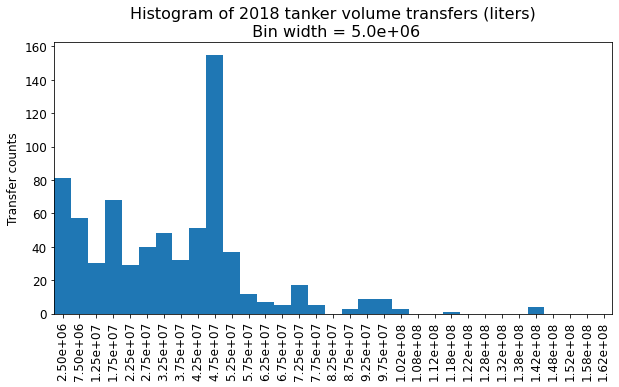

In [28]:
   
fig, ax = plt.subplots(figsize=(10, 5))
bin_width = 5e6
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
#plt.xlabel("Bin Number")
plt.title(f"Histogram of 2018 tanker volume transfers (liters)\n Bin width = {bin_width:1.1e}")
plt.show()

#### Thoughts:
- **Handimax** has the most number of ship tracks in 2018. The 4.5-5e7 liter size class is consistent with Handimax size.  
- The cargo capacities we are using based on SILO are: 
    - **smallest tanker** 5.8e5
    - **small tanker** 1.5e7
    - **handymax**	5.3e7
    - **aframax**	1.26e8
    - **suezmax**	1.85e8
- According to the [ATC](https://www.aktanker.com/fleet-main) website, **Alaskan Explorer's carrying capacity is 206,683,483.4 liters**.  This is true of all their tankers, three of which are the first three in AIS ship track counts in 2018.  
    - 366948190.0   5940
    - 303656000.0  24133
    - 303294000.0  29376
    - 367688000.0  25157
- **Suezmax**:The max transfer is 1.5e8 liters.  Max capacity is 2.1e8.  We classify max capacity of Suezmax as 1.85e8.  
- We use 5 values of oil cargo capacity for tankers based on their size class. The DOE transfers suggest the following max cargo capacities for these categories
    - **Smallest tanker**: 5.8e5 (based on max transfers for MMSI with most ship tracks, also, [Global Provider](https://www.professionalmariner.com/global-provider/) is given a cargo capacity of 567811.768)
    - **Small tanker**: 1.5e7 (based on max transfers for MMSI  with most ship tracks)
    - **Small tanker**: 1.75e7 (based on histogram)
    - **Handymax**: 4e7 (based on max transfers for the two MMSI with most ship tracks)
    - **Handymax**: 4.75e7 (based on histogram)
    - **Aframax**: 1.2e8 (based on histogram)
    - **Suezmax**: 1.5e8 (based on histogram, this is ~71% capacity)
- **Question**: Do we want to adjust any of the values that we are using?  The values I am considering changing are:
    
    -**HandiMax** from 5.3e7 to 4.75e7 and 
    -**Suezmax** from 1.85e8 to 1.5e8. 

In [43]:
percent_total={}
percent_total['Small']=sum(
    binned_mmsi['Small Tanker (61 - 150 m)'].COUNT.iloc[0:3])/\
    sum(binned_mmsi['Small Tanker (61 - 150 m)'].COUNT
   )
percent_total['Handimax']=sum(
    binned_mmsi['Handymax (151-200 m)'].COUNT.iloc[0:20])/\
    sum(binned_mmsi['Handymax (151-200 m)'].COUNT
   )
percent_total['Aframax']=sum(
    binned_mmsi["Aframax (201-250 m)"].COUNT.iloc[0:5])/\
    sum(binned_mmsi["Aframax (201-250 m)"].COUNT
   )
percent_total['Suezmax']=sum(
    binned_mmsi['Suezmax (251-300 m)'].COUNT.iloc[0:4])/\
    sum(binned_mmsi['Suezmax (251-300 m)'].COUNT
   )

percent_total['Handimax']

0.5815117036757526

In [44]:
binned_mmsi['Handymax (151-200 m)'].iloc[0:20]

,COUNT
MMSI_NUM,
369042000.0,41383
367353110.0,37996
366855000.0,32830
367134000.0,31026
369040000.0,26513
356159000.0,17697
212656000.0,15659
538006302.0,15417
538004682.0,13344


In [30]:
percent_total['Small']

0.5455446713088634

### Check Small tankers 

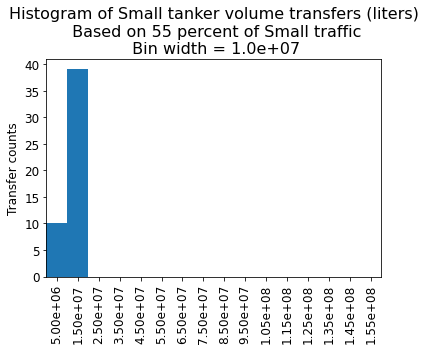

18283530.3

In [31]:
# Get transfers for these two examples of Handimax 
vessels = ["KIRKEHOLMEN","MTM HOUSTON","BOCHEM LONDON"] 
vessel_type = 'Small'
volume = {}
volume[vessel_type] = get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path)

# plot histogram of handimax transfers
fig, ax = plt.subplots()
bin_width = 1e7
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
plt.title(f"Histogram of Small tanker volume transfers (liters)\n Based on {100*percent_total['Small']:.0f} percent of Small traffic\n Bin width = {bin_width:1.1e}")
plt.show()

max(volume[vessel_type]['TransferQtyInLiters'])

### Check HandiMax tankers using transfers for the ten vessels with the most AIS ship tracks

KeyError: 'Handymax (151-200 m)'

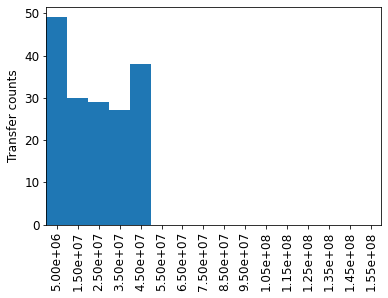

In [50]:
# Get transfers for these two examples of Handimax 
vessels = ["AMERICAN FREEDOM","PELICAN STATE", "FLORIDA",
          'PANAGIA THALASSINI','CHEMBULK LINDY ALICE','ZAO GALAXY',
           'OVERSEAS LOS ANGELES','AMERICAN ENDURANCE','OPEC VICTORY','SONGA PRIDE',] 
vessel_type = 'HandiMax'
volume = {}
volume[vessel_type] = get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path)

# plot histogram of handimax transfers
fig, ax = plt.subplots()
bin_width = 1e7
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
plt.title(f"Histogram of HandiMax tanker volume transfers (liters)\n Based on {100*percent_total['Handimax']:.0f} percent of HandiMax traffic\n Bin width = {bin_width:1.1e}")
plt.show()

max(volume['HandiMax']['TransferQtyInLiters'])

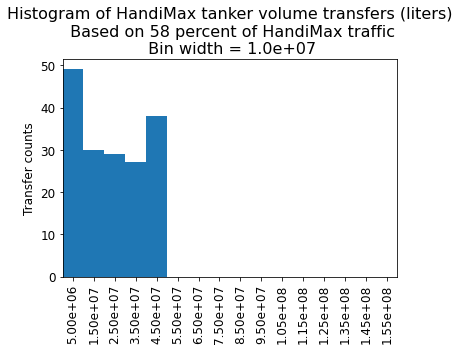

,TransferQtyInLiters,Deliverer,Receiver,StartDateTime
AntID,,,,
176737,4.880908e+07,FLORIDA,Marathon Anacortes Refinery (formerly Tesoro),2018-04-13 12:30:00
184090,4.769617e+07,AMERICAN ENDURANCE,BP Cherry Point Refinery,2018-09-30 06:00:00
179259,4.769617e+07,Marathon Anacortes Refinery (formerly Tesoro),FLORIDA,2018-06-10 19:00:00
177737,4.769617e+07,Marathon Anacortes Refinery (formerly Tesoro),AMERICAN ENDURANCE,2018-05-09 02:30:00
186907,4.690123e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-12-31 07:00:00
185339,4.610629e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-11-08 05:00:00
179694,4.610629e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-06-25 06:00:00
184569,4.610629e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-10-14 08:00:00
185048,4.610629e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-10-28 14:00:00


In [53]:
vessels = ["AMERICAN FREEDOM","PELICAN STATE", "FLORIDA",
          'PANAGIA THALASSINI','CHEMBULK LINDY ALICE','ZAO GALAXY',
           'OVERSEAS LOS ANGELES','AMERICAN ENDURANCE','OPEC VICTORY','SONGA PRIDE',] 
vessel_type = 'HandiMax'
volume = {}
volume[vessel_type] = get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path)
pandas.set_option('display.max_rows', volume[vessel_type].shape[0]+1)


# plot histogram of handimax transfers
fig, ax = plt.subplots()
bin_width = 1e7
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
plt.title(f"Histogram of HandiMax tanker volume transfers (liters)\n Based on {100*percent_total['Handimax']:.0f} percent of HandiMax traffic\n Bin width = {bin_width:1.1e}")
plt.show()



In [57]:
volume[vessel_type].sort_values(by='StartDateTime').reset_index()

,AntID,TransferQtyInLiters,Deliverer,Receiver,StartDateTime
0,173668,4.578832e+07,BP Cherry Point Refinery,PELICAN STATE,2018-01-07 16:30:00
1,173766,4.260857e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-01-09 00:01:00
2,173900,7.313412e+06,OVERSEAS LOS ANGELES,BP Cherry Point Refinery,2018-01-09 05:00:00
3,174103,4.292655e+07,BP Cherry Point Refinery,PELICAN STATE,2018-01-22 15:00:00
4,174264,2.861770e+07,AMERICAN ENDURANCE,Marathon Anacortes Refinery (formerly Tesoro),2018-01-22 19:30:00
5,174265,1.748859e+07,Marathon Anacortes Refinery (formerly Tesoro),AMERICAN ENDURANCE,2018-01-22 19:30:00
6,174153,1.241879e+07,CHEMBULK LINDY ALICE,"REG Grays Harbor, LLC",2018-01-24 14:00:00
7,174356,3.020757e+07,AMERICAN FREEDOM,Marathon Anacortes Refinery (formerly Tesoro),2018-01-25 11:00:00
8,174415,4.181364e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-01-29 23:00:00
9,174678,4.515237e+07,BP Cherry Point Refinery,PELICAN STATE,2018-02-06 07:00:00


In [84]:
#volume[vessel_type]=volume[vessel_type].sort_values(by='StartDateTime').reset_index()
handimax_both=pandas.DataFrame({})
handimax_single=pandas.DataFrame({})
count = 0
idx_taken = 0
for idx,deliverer in enumerate(volume[vessel_type]['Deliverer']):
    if idx != volume[vessel_type]['Deliverer'].shape[0]-1:
        if ((volume[vessel_type]['Deliverer'][idx] == volume[vessel_type]['Receiver'][idx+1]) &
            (volume[vessel_type]['Deliverer'][idx+1] == volume[vessel_type]['Receiver'][idx])):
            # count number of cases where there is a delivery both ways
            count += 1
            handimax_both = handimax_both.append(volume[vessel_type].iloc[[idx]])
            idx_taken = 1
        else:
            if idx_taken:
                handimax_both = handimax_both.append(volume[vessel_type].iloc[[idx]])
                idx_taken = 0
            else:
                handimax_single = handimax_single.append(volume[vessel_type].iloc[[idx]])
                idx_taken = 0

In [85]:
pandas.set_option('display.max_rows', handimax_single.shape[0]+1)
handimax_single

,level_0,index,AntID,TransferQtyInLiters,Deliverer,Receiver,StartDateTime
0,0,0,173668,4.578832e+07,BP Cherry Point Refinery,PELICAN STATE,2018-01-07 16:30:00
3,3,3,174103,4.292655e+07,BP Cherry Point Refinery,PELICAN STATE,2018-01-22 15:00:00
6,6,6,174153,1.241879e+07,CHEMBULK LINDY ALICE,"REG Grays Harbor, LLC",2018-01-24 14:00:00
7,7,7,174356,3.020757e+07,AMERICAN FREEDOM,Marathon Anacortes Refinery (formerly Tesoro),2018-01-25 11:00:00
8,8,8,174415,4.181364e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-01-29 23:00:00
9,9,9,174678,4.515237e+07,BP Cherry Point Refinery,PELICAN STATE,2018-02-06 07:00:00
12,12,12,175012,2.782276e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-02-13 11:00:00
13,13,13,175123,3.736200e+07,BP Cherry Point Refinery,PELICAN STATE,2018-02-19 12:00:00
14,14,14,175199,3.200413e+07,AMERICAN ENDURANCE,Marathon Anacortes Refinery (formerly Tesoro),2018-02-21 21:00:00
15,15,15,175203,2.782276e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-02-22 10:00:00


In [86]:
pandas.set_option('display.max_rows', handimax_both.shape[0]+1)
handimax_both

,level_0,index,AntID,TransferQtyInLiters,Deliverer,Receiver,StartDateTime
1,1,1,173766,4.260857e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-01-09 00:01:00
2,2,2,173900,7.313412e+06,OVERSEAS LOS ANGELES,BP Cherry Point Refinery,2018-01-09 05:00:00
4,4,4,174264,2.861770e+07,AMERICAN ENDURANCE,Marathon Anacortes Refinery (formerly Tesoro),2018-01-22 19:30:00
5,5,5,174265,1.748859e+07,Marathon Anacortes Refinery (formerly Tesoro),AMERICAN ENDURANCE,2018-01-22 19:30:00
10,11,10,174966,7.949361e+05,AMERICAN FREEDOM,Marathon Anacortes Refinery (formerly Tesoro),2018-02-11 13:00:00
11,10,11,174965,3.084352e+07,Marathon Anacortes Refinery (formerly Tesoro),AMERICAN FREEDOM,2018-02-11 13:00:00
20,21,20,176035,6.995438e+05,AMERICAN ENDURANCE,Marathon Anacortes Refinery (formerly Tesoro),2018-03-17 07:00:00
21,20,21,176034,3.179744e+07,Marathon Anacortes Refinery (formerly Tesoro),AMERICAN ENDURANCE,2018-03-17 07:00:00
27,27,27,176492,2.623289e+07,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-04-01 13:00:00
28,28,28,176491,1.112911e+07,OVERSEAS LOS ANGELES,BP Cherry Point Refinery,2018-04-01 13:00:00


In [64]:
volume[vessel_type]['Deliverer'].shape[0]

173

In [63]:
count

38

Text(0.5, 1.0, 'Handimax transfer quantities (liters) for vessels that are 50% full')

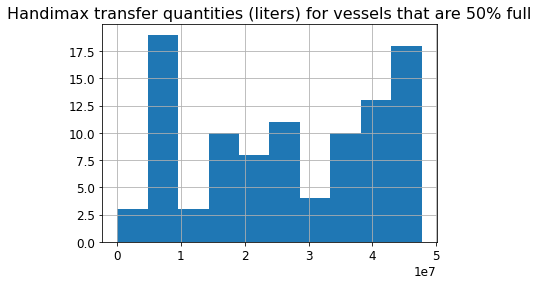

In [92]:
ax = handimax_single['TransferQtyInLiters'].hist()
ax.set_title('Handimax transfer quantities (liters) for vessels that are 50% full')

Text(0.5, 1.0, 'Handimax transfer quantities (liters) for vessels that are 100% full')

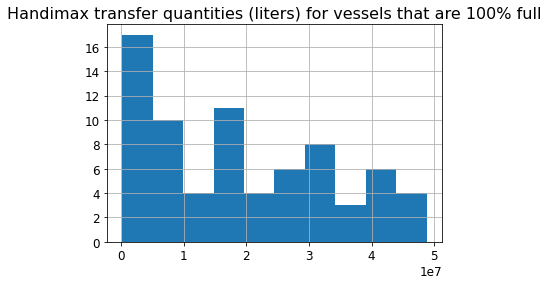

In [90]:
ax = handimax_both['TransferQtyInLiters'].hist()
ax.set_title('Handimax transfer quantities (liters) for vessels that are 100% full')

Text(0.5, 1.0, 'Handimax transfer quantities (liters) for all vessels')

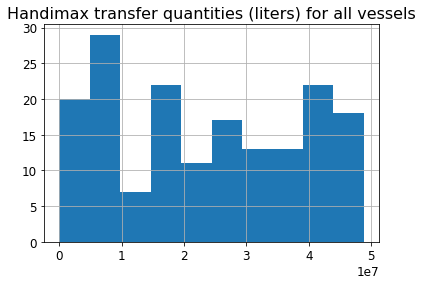

In [93]:
handimax_combined = handimax_single.append(handimax_both)
ax = handimax_combined['TransferQtyInLiters'].hist()
ax.set_title('Handimax transfer quantities (liters) for all vessels')

In [67]:
handimax_volume = handimax_volume.drop([handimax_volume.index[0]])
handimax_volume.head(2)

,index,AntID,TransferQtyInLiters,Deliverer,Receiver,StartDateTime
1,1,173766,42608574.96,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-01-09 00:01:00
2,2,173900,7313412.12,OVERSEAS LOS ANGELES,BP Cherry Point Refinery,2018-01-09 05:00:00


### Show histograms of Aframax transfers 

In [33]:
binned_mmsi["Aframax (201-250 m)"].iloc[:5]

,COUNT
MMSI_NUM,
636015178.0,6057
220518000.0,5718
255806154.0,5140
311943000.0,4609
538001893.0,4172


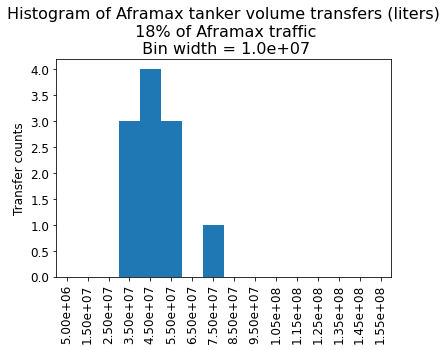

79493610.0

In [34]:
vessels = ["AQUALEGACY","TORM EMILIE","NORDTULIP","GULF PEARL","ELAN VITAL"] 
vessel_type = 'Aframax'
volume = {}
volume[vessel_type] = get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path)

# plot histogram of handimax transfers
fig, ax = plt.subplots()
bin_width = 1e7
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
plt.title(f"Histogram of Aframax tanker volume transfers (liters)\n {100*percent_total['Aframax']:.0f}% of Aframax traffic\n Bin width = {bin_width:1.1e}")
plt.show()

max(volume['Aframax']['TransferQtyInLiters'])

### Take away:  In some cases, multiple AntIDs are used to represent cargo transfers for a given voyage.  The sum of these is close to 1e8, which approximates SILO value of 1.26e8

### Show histograms of Suezmax transfers 

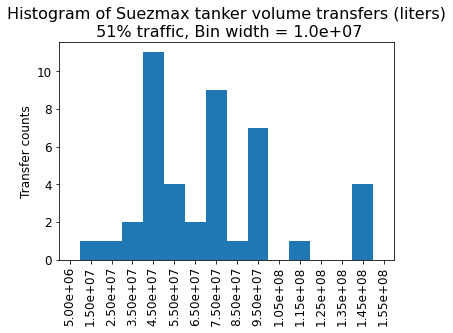

143337002.59568

In [35]:
vessels = ['ALASKAN EXPLORER', "ALASKAN NAVIGATOR", "ALASKA LEGEND", "ALASKA FRONTIER"] 
vessel_type = 'Suezmax'
volume[vessel_type] = get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path)

fig, ax = plt.subplots()
bin_width = 1e7
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
plt.title(f"Histogram of Suezmax tanker volume transfers (liters)\n {100*percent_total['Suezmax']:.0f}% traffic, Bin width = {bin_width:1.1e}")
plt.show()

max(volume['Suezmax']['TransferQtyInLiters'])

# Cargo transfer evaluations 

### Handimax

In [36]:
vessels = ["AMERICAN FREEDOM","PELICAN STATE", "FLORIDA",
          'PANAGIA THALASSINI','CHEMBULK LINDY ALICE','ZAO GALAXY',
           'OVERSEAS LOS ANGELES','AMERICAN ENDURANCE','OPEC VICTORY','SONGA PRIDE',] 
vessel_type = 'Handimax'

### Get a sense of behavior with fueling
volume[vessel_type] = DOEdf.loc[
    (DOEdf.Deliverer.isin(vessels) |
     DOEdf.Receiver.isin(vessels)),
    ['TransferQtyInGallon', 'Deliverer','Receiver','StartDateTime','AntID']
].groupby('AntID').agg(
    {'TransferQtyInGallon':'sum','Deliverer':'first', 'Receiver':'first','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)

volume[vessel_type]['TransferQtyInLiters'] = gal2liter*volume[vessel_type]['TransferQtyInGallon']
volume[vessel_type]=volume[vessel_type].sort_values(by='StartDateTime')
pandas.set_option('display.max_rows', volume[vessel_type].shape[0]+1)
volume[vessel_type]

,TransferQtyInGallon,Deliverer,Receiver,StartDateTime,TransferQtyInLiters
AntID,,,,,
173668,12096000.0,BP Cherry Point Refinery,PELICAN STATE,2018-01-07 16:30:00,4.578832e+07
173766,11256000.0,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-01-09 00:01:00,4.260857e+07
173900,2289000.0,OVERSEAS LOS ANGELES,BP Cherry Point Refinery,2018-01-09 05:00:00,8.664803e+06
174271,206684.0,HMS 26-1,PELICAN STATE,2018-01-22 07:00:00,7.823837e+05
174103,11340000.0,BP Cherry Point Refinery,PELICAN STATE,2018-01-22 15:00:00,4.292655e+07
174265,4620000.0,Marathon Anacortes Refinery (formerly Tesoro),AMERICAN ENDURANCE,2018-01-22 19:30:00,1.748859e+07
174264,7560000.0,AMERICAN ENDURANCE,Marathon Anacortes Refinery (formerly Tesoro),2018-01-22 19:30:00,2.861770e+07
174281,287061.0,HMS 2000,AMERICAN FREEDOM,2018-01-23 11:00:00,1.086644e+06
174153,3280700.0,CHEMBULK LINDY ALICE,"REG Grays Harbor, LLC",2018-01-24 14:00:00,1.241879e+07


### Aframax

In [37]:
### Get a sense of behavior with fueling
volume['Aframax'] = DOEdf.loc[
    (DOEdf.Deliverer.isin(["AQUALEGACY","TORM EMILIE","NORDTULIP","GULF PEARL","ELAN VITAL"] ) |
     DOEdf.Receiver.isin(["AQUALEGACY","TORM EMILIE","NORDTULIP","GULF PEARL","ELAN VITAL"] )),
    ['TransferQtyInGallon', 'Deliverer','Receiver','StartDateTime','AntID']
].groupby('AntID').agg(
    {'TransferQtyInGallon':'sum','Deliverer':'first', 'Receiver':'first','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)

volume['Aframax']['TransferQtyInLiters'] = gal2liter*volume['Aframax']['TransferQtyInGallon']
volume['Aframax']=volume['Aframax'].sort_values(by='StartDateTime')
pandas.set_option('display.max_rows', volume['Aframax'].shape[0]+1)
volume['Aframax']

,TransferQtyInGallon,Deliverer,Receiver,StartDateTime,TransferQtyInLiters
AntID,,,,,
173665,9408000.0,BP Cherry Point Refinery,TORM EMILIE,2018-01-06 07:00:00,3.561314e+07
173852,15582000.0,BP Cherry Point Refinery,TORM EMILIE,2018-01-13 09:00:00,5.898426e+07
175412,278859.0,HMS 2000,TORM EMILIE,2018-02-26 10:00:00,1.055596e+06
177564,196841.0,HMS 2000,TORM EMILIE,2018-05-02 19:00:00,7.451239e+05
177195,21000000.0,TORM EMILIE,BP Cherry Point Refinery,2018-05-07 09:00:00,7.949361e+07
179965,8400000.0,AQUALEGACY,Shell Puget Sound Refinery,2018-06-28 14:00:00,3.179744e+07
180176,8400000.0,AQUALEGACY,Shell Puget Sound Refinery,2018-07-01 12:00:00,3.179744e+07
180194,426490.0,HMS 2000,AQUALEGACY,2018-07-02 14:00:00,1.614440e+06
181416,11550000.0,NORDTULIP,BP Cherry Point Refinery,2018-08-02 14:00:00,4.372149e+07


### Suezmax

#### Take-away:  Indeed...big boats distribute in smaller transfers.  Show transfers to evaluate.

In [38]:
volume['Suezmax']=volume['Suezmax'].sort_values(by='StartDateTime')
pandas.set_option('display.max_rows', volume['Suezmax'].shape[0]+1)
volume['Suezmax']

,TransferQtyInLiters,Deliverer,Receiver,StartDateTime
AntID,,,,
173584,4.769617e+07,ALASKAN NAVIGATOR,Marathon Anacortes Refinery (formerly Tesoro),2018-01-02 12:00:00
173667,7.154425e+07,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-07 21:30:00
173850,7.297513e+07,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-12 14:00:00
174331,3.179744e+07,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-01-24 00:01:00
174335,9.381343e+07,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-27 13:00:00
174495,4.769617e+07,ALASKAN EXPLORER,Shell Puget Sound Refinery,2018-01-30 12:00:00
174614,9.602828e+07,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-02-04 09:30:00
174716,4.769617e+07,ALASKAN NAVIGATOR,Shell Puget Sound Refinery,2018-02-06 10:00:00
174923,7.154425e+07,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-02-16 08:00:00


In [39]:
### Get a sense of behavior with fueling
volume['Suezmax'] = DOEdf.loc[
    (DOEdf.Deliverer.isin(['ALASKAN EXPLORER', "ALASKAN NAVIGATOR", "ALASKA LEGEND", "ALASKA FRONTIER"]) |
     DOEdf.Receiver.isin(['ALASKAN EXPLORER', "ALASKAN NAVIGATOR", "ALASKA LEGEND", "ALASKA FRONTIER"])),
    ['TransferQtyInGallon', 'Deliverer','Receiver','StartDateTime','AntID']
].groupby('AntID').agg(
    {'TransferQtyInGallon':'sum','Deliverer':'first', 'Receiver':'first','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)

volume['Suezmax']['TransferQtyInLiters'] = gal2liter*volume['Suezmax']['TransferQtyInGallon']
volume['Suezmax']=volume['Suezmax'].sort_values(by='StartDateTime')
pandas.set_option('display.max_rows', volume['Suezmax'].shape[0]+1)
volume['Suezmax']

,TransferQtyInGallon,Deliverer,Receiver,StartDateTime,TransferQtyInLiters
AntID,,,,,
173584,12600000.0,ALASKAN NAVIGATOR,Marathon Anacortes Refinery (formerly Tesoro),2018-01-02 12:00:00,4.769617e+07
173658,524912.0,HMS 26-1,ALASKAN NAVIGATOR,2018-01-04 06:00:00,1.987007e+06
173667,18900000.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-07 21:30:00,7.154425e+07
173923,206684.0,GLOBAL PILOT,ALASKAN EXPLORER,2018-01-11 07:00:00,7.823837e+05
173850,19278000.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-12 14:00:00,7.297513e+07
174331,8400000.0,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-01-24 00:01:00,3.179744e+07
174335,24782898.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-27 13:00:00,9.381343e+07
174495,12600000.0,ALASKAN EXPLORER,Shell Puget Sound Refinery,2018-01-30 12:00:00,4.769617e+07
174614,25368000.0,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-02-04 09:30:00,9.602828e+07


## Aframax

In [40]:
### Get a sense of behavior with fueling
volume['Suezmax'] = DOEdf.loc[
    (DOEdf.Deliverer.isin(['ALASKAN EXPLORER', "ALASKAN NAVIGATOR", "ALASKA LEGEND", "ALASKA FRONTIER"]) |
     DOEdf.Receiver.isin(['ALASKAN EXPLORER', "ALASKAN NAVIGATOR", "ALASKA LEGEND", "ALASKA FRONTIER"])),
    ['TransferQtyInGallon', 'Deliverer','Receiver','StartDateTime','AntID']
].groupby('AntID').agg(
    {'TransferQtyInGallon':'sum','Deliverer':'first', 'Receiver':'first','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)

volume['Suezmax']['TransferQtyInLiters'] = gal2liter*volume['Suezmax']['TransferQtyInGallon']
volume['Suezmax']=volume['Suezmax'].sort_values(by='StartDateTime')
pandas.set_option('display.max_rows', volume['Suezmax'].shape[0]+1)
volume['Suezmax']

,TransferQtyInGallon,Deliverer,Receiver,StartDateTime,TransferQtyInLiters
AntID,,,,,
173584,12600000.0,ALASKAN NAVIGATOR,Marathon Anacortes Refinery (formerly Tesoro),2018-01-02 12:00:00,4.769617e+07
173658,524912.0,HMS 26-1,ALASKAN NAVIGATOR,2018-01-04 06:00:00,1.987007e+06
173667,18900000.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-07 21:30:00,7.154425e+07
173923,206684.0,GLOBAL PILOT,ALASKAN EXPLORER,2018-01-11 07:00:00,7.823837e+05
173850,19278000.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-12 14:00:00,7.297513e+07
174331,8400000.0,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-01-24 00:01:00,3.179744e+07
174335,24782898.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-27 13:00:00,9.381343e+07
174495,12600000.0,ALASKAN EXPLORER,Shell Puget Sound Refinery,2018-01-30 12:00:00,4.769617e+07
174614,25368000.0,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-02-04 09:30:00,9.602828e+07


In [41]:
volume['HandiMax'].shape

KeyError: 'HandiMax'

In [ ]:
6.359489+7.9+9.3

In [ ]:
#8/8-8/12, 367688000: Alaska Navigator
allTracks["tanker"].head(1)

In [ ]:
from datetime import datetime
datetime(2018, 8, 1)

In [ ]:
print(subsmpl.geometry[26153])